In [11]:
# Import core libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import machine learning tools from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize
from sklearn.dummy import DummyClassifier

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

### Parameter Setup

We define a configuration dictionary containing parameters used throughout the notebook:
- File paths,
- Columns to include/exclude from machine learning or correlation analysis,
- Generation cutoffs,
- Random seed for reproducibility.

In [12]:
# Define key configuration parameters for preprocessing and modeling
params = { 
    # path to ML-ready dataset
    'for_ml' : '../processed/ambitus_0_15_ml_ready_04_08_2025.csv',
    # categorical string columns
    'str_cols' : ['Group', 'Sex', 'Season'],
    # columns to exclude from ML
    'not_for_ml' : ['Group', 'Sex', 'Season', 'NR', 'Year', 'Paradigm', 'id', 'Generation'],
    # excluded from correlation
    'not_corr_cols' : ['Group', 'Sex', 'Season', 'NR', 'Year', 'Paradigm', 'id', 'Generation', 'Group'],
    # upper bound for analysis range
    'generation_cut' : 13,
    # lower bound for analysis range
    'generation_under_cut' : 6,
    # random seed for reproducibility
    'seed' : 42
}

In [13]:
#Readading the data
data = pd.read_csv(params['for_ml'])
data

,Generation,Season,Paradigm,Year,NR,Group,Sex,EAT_E_%,EAT_I_%,EAT_TOT_%%,...,A_E_4,Expl_E_BEF_Loco_ratio_4,Expl_I_BEF_Loco_ratio_4,Expl_EI_BEF_Loco_ratio_4,Expl_E_TOT_Loco_ratio_4,Expl_I_TOT_Loco_ratio_4,Expl_E_I_TOT_Loco_ratio_4,Eff_Expl_I_4,Eff_Expl_EI_4,E_E_4
0,0,Autumn,1,0,1,Lisket,Male,100.0,75.0,87.50,...,27.586207,1.666667,3.166667,4.833333,1.857143,2.357143,4.214286,1.0,0.500000,1.0
1,0,Autumn,1,0,2,Lisket,Male,87.5,75.0,81.25,...,33.333333,2.666667,5.333333,8.000000,1.529412,2.117647,3.647059,1.0,0.571429,1.0
2,0,Autumn,1,0,3,Lisket,Male,100.0,75.0,87.50,...,40.000000,3.000000,7.000000,10.000000,2.076923,3.076923,5.153846,1.0,0.571429,1.0
3,0,Autumn,1,0,4,LE,Male,87.5,87.5,87.50,...,30.769231,4.500000,8.500000,13.000000,2.818182,3.727273,6.545455,1.0,0.571429,1.0
4,0,Autumn,1,0,5,Lisket,Male,50.0,75.0,62.50,...,33.333333,2.666667,5.333333,8.000000,1.888889,3.222222,5.111111,1.0,0.533333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,15,Winter,1,6,95,LE,Male,87.5,50.0,68.75,...,25.806452,2.000000,3.166667,5.166667,1.105263,1.578947,2.684211,1.0,0.500000,1.0
1338,15,Winter,1,6,96,LE,Male,100.0,75.0,87.50,...,34.782609,1.166667,2.666667,3.833333,1.260870,1.565217,2.826087,1.0,0.571429,1.0
1339,15,Winter,1,6,97,LE,Male,100.0,75.0,87.50,...,44.444444,0.500000,1.750000,2.250000,1.350000,1.450000,2.800000,1.0,0.666667,1.0
1340,15,Winter,1,6,98,LE,Male,100.0,100.0,100.00,...,32.000000,0.900000,1.600000,2.500000,0.968750,1.343750,2.312500,1.0,0.533333,1.0


In [14]:
pd.DataFrame(data.columns).to_csv('ml_cols.csv', index=False)

### Generation-wise Feature Normalization

To account for differences in scale across generations, we normalize the numeric features within each generation separately. This ensures that comparisons across individuals are not biased by generation-specific shifts in feature distributions.

In [15]:
# Perform generation-wise normalization of numeric features
data_normalized = data.copy()
# Loop over each generation separately
for gen in data['Generation'].unique():
    gen_data = data[data['Generation'] == gen]
    # Select numeric columns that are not excluded
    numeric_cols = [col for col in gen_data.columns if col not in params['not_for_ml'] and gen_data[col].dtype in ['float64', 'int64']]
    # Normalize the numeric features within this generation
    data_normalized.loc[data['Generation'] == gen, numeric_cols] = normalize(gen_data[numeric_cols])
# Display the normalized dataset
data_normalized

,Generation,Season,Paradigm,Year,NR,Group,Sex,EAT_E_%,EAT_I_%,EAT_TOT_%%,...,A_E_4,Expl_E_BEF_Loco_ratio_4,Expl_I_BEF_Loco_ratio_4,Expl_EI_BEF_Loco_ratio_4,Expl_E_TOT_Loco_ratio_4,Expl_I_TOT_Loco_ratio_4,Expl_E_I_TOT_Loco_ratio_4,Eff_Expl_I_4,Eff_Expl_EI_4,E_E_4
0,0,Autumn,1,0,1,Lisket,Male,0.001262,0.000947,0.001104,...,0.000348,0.000021,0.000040,0.000061,0.000023,0.000030,0.000053,0.000013,0.000006,0.000013
1,0,Autumn,1,0,2,Lisket,Male,0.000892,0.000764,0.000828,...,0.000340,0.000027,0.000054,0.000082,0.000016,0.000022,0.000037,0.000010,0.000006,0.000010
2,0,Autumn,1,0,3,Lisket,Male,0.001080,0.000810,0.000945,...,0.000432,0.000032,0.000076,0.000108,0.000022,0.000033,0.000056,0.000011,0.000006,0.000011
3,0,Autumn,1,0,4,LE,Male,0.001041,0.001041,0.001041,...,0.000366,0.000054,0.000101,0.000155,0.000034,0.000044,0.000078,0.000012,0.000007,0.000012
4,0,Autumn,1,0,5,Lisket,Male,0.000736,0.001104,0.000920,...,0.000491,0.000039,0.000079,0.000118,0.000028,0.000047,0.000075,0.000015,0.000008,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,15,Winter,1,6,95,LE,Male,0.000960,0.000548,0.000754,...,0.000283,0.000022,0.000035,0.000057,0.000012,0.000017,0.000029,0.000011,0.000005,0.000011
1338,15,Winter,1,6,96,LE,Male,0.000759,0.000569,0.000664,...,0.000264,0.000009,0.000020,0.000029,0.000010,0.000012,0.000021,0.000008,0.000004,0.000008
1339,15,Winter,1,6,97,LE,Male,0.000873,0.000654,0.000763,...,0.000388,0.000004,0.000015,0.000020,0.000012,0.000013,0.000024,0.000009,0.000006,0.000009
1340,15,Winter,1,6,98,LE,Male,0.000693,0.000693,0.000693,...,0.000222,0.000006,0.000011,0.000017,0.000007,0.000009,0.000016,0.000007,0.000004,0.000007


### Train/Test Split Based on Generations

To simulate real-world generalization, we split the dataset into training and test sets based on generation numbers:
- The training set includes data from intermediate generations (e.g., Gen 7–13).
- The test set includes data from later generations (e.g., Gen 14+).
- The target variable is Group, indicating experimental grouping.

This strategy ensures that the model is evaluated on unseen generations, mimicking chronological drift.

-> Playground cell <-

You can customize how the machine learning model is trained and evaluated by modifying the following parameters:
- params['generation_cut']: Upper boundary for training generations
- params['generation_under_cut']: Lower boundary for training generations
- params['not_for_ml']: Columns to exclude from modeling (e.g., metadata or labels)

Try experimenting with different values to explore:
- How well the model generalizes to future generations
- The effect of excluding or including additional features
- Model performance on different target variables (e.g., Sex instead of Group)

This setup encourages interactive model development and experimentation.

In [16]:
# Create training and testing sets based on generation thresholds
# Features for training: generations between lower and upper cut
X_train = data.loc[(data['Generation'] <= params['generation_cut']) & (data['Generation'] > params['generation_under_cut'])].drop(columns=params['not_for_ml'])
# Features for testing: generations after the upper cutoff
X_test = data.loc[data['Generation'] > params['generation_cut']].drop(columns=params['not_for_ml'])
# Labels for training and testing (target = Group)
y_train = data.loc[(data['Generation'] <= params['generation_cut']) & (data['Generation'] > params['generation_under_cut']), 'Group']
y_test = data.loc[data['Generation'] > params['generation_cut'], 'Group']

### Target Variable Distribution – Training Set

Before training any machine learning model, it's essential to check whether the target variable is balanced or skewed.
This plot shows the distribution of the Group labels in the training set.
- Uneven group sizes may lead to biased classification.
- Consider techniques like class weighting, oversampling, or undersampling if imbalance is significant.

You can also create a similar plot for the test set to compare distributions.

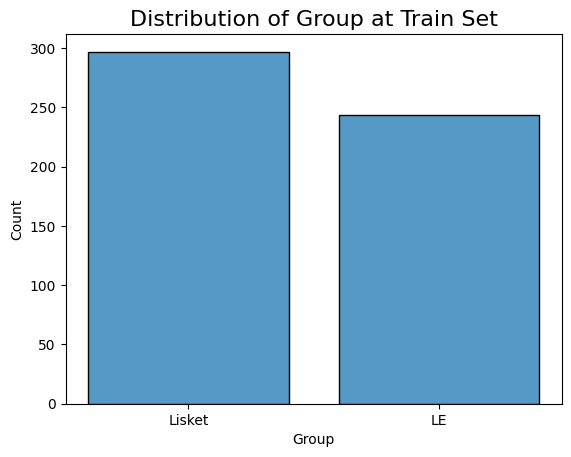

In [17]:
#Plotting label distribution in train and test sets
sns.histplot(pd.DataFrame(y_train), x='Group', multiple='dodge', shrink=0.8)
plt.title('Distribution of Group at Train Set', fontsize=16)
plt.show()


### Baseline Model: Dummy Classifier

The DummyClassifier provides a simple baseline by making predictions using simple rules, such as always predicting the most frequent class. It helps answer the question:
- “Is my real model actually better than guessing?”

In this setup:
- Strategy: 'most_frequent' – always predicts the majority class from the training set.
- You can also try other strategies like 'stratified', 'uniform', or 'prior'.

Use the Dummy Classifier as a sanity check. If your actual model does not outperform this, you may need to revisit your feature engineering or modeling strategy.

Dummy Classifier – Classification Report:
              precision    recall  f1-score   support

          LE       0.00      0.00      0.00        84
      Lisket       0.55      1.00      0.71       104

    accuracy                           0.55       188
   macro avg       0.28      0.50      0.36       188
weighted avg       0.31      0.55      0.39       188



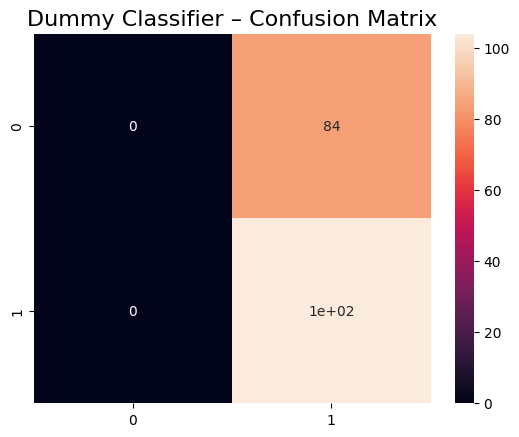

In [18]:
# Create a dummy classifier as a baseline model
dummy = DummyClassifier(strategy='most_frequent', random_state=params['seed'])
dummy.fit(X_train, y_train)

# Predict and evaluate
y_dummy_pred = dummy.predict(X_test)

print("Dummy Classifier – Classification Report:")
print(classification_report(y_test, y_dummy_pred))

# Plot confusion matrix
cm_dummy = confusion_matrix(y_test, y_dummy_pred)
sns.heatmap(cm_dummy, annot=True)
plt.title('Dummy Classifier – Confusion Matrix', fontsize=16)
plt.show()

### Decision Tree Classifier

-> Playground cell <-

This is your model playground! The current pipeline uses a DecisionTreeClassifier, but you can easily replace it with other classifiers from scikit-learn, such as:
- RandomForestClassifier()
- LogisticRegression()
- GradientBoostingClassifier()
- SVC() (Support Vector Machine)

You can also tune parameters like:
- max_depth, min_samples_leaf (for tree-based models)
- n_estimators, learning_rate (for ensemble models)

After modifying the model, check:
- Classification performance (accuracy, precision, recall, F1)
- Confusion matrix to understand misclassification patterns

Feel free to experiment and compare different setups!

Classification Report:
              precision    recall  f1-score   support

          LE       0.60      0.88      0.71        84
      Lisket       0.84      0.52      0.64       104

    accuracy                           0.68       188
   macro avg       0.72      0.70      0.68       188
weighted avg       0.73      0.68      0.67       188



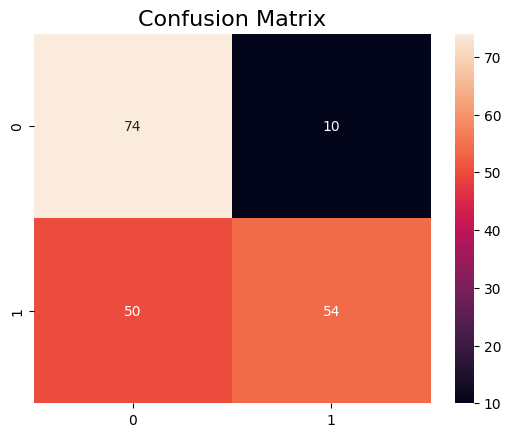

In [19]:
# Build a simple ML pipeline using a Decision Tree Classifier
pipeline = Pipeline([('tree', DecisionTreeClassifier(random_state=params['seed'], max_depth=5, min_samples_leaf=6))])
# Train the model
pipeline.fit(X_train, y_train)
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print classification performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

### Feature Importance (Model-Dependent)

This plot shows which features were most important in the model’s decision-making process.

Important Note:
This method only works for models that expose .feature_importances_, such as:
- DecisionTreeClassifier
- RandomForestClassifier
- GradientBoostingClassifier

If you switch to a model that does not support feature importances (e.g., LogisticRegression, SVC, KNeighborsClassifier), this cell will raise an error.

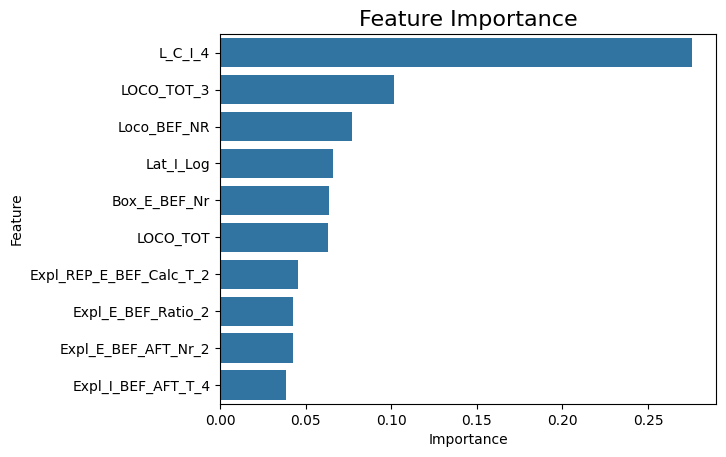

In [20]:
# Plot feature importances from the fitted decision tree model
if hasattr(pipeline.named_steps['tree'], 'feature_importances_'):
    # Extract importance scores
    importances = pipeline.named_steps['tree'].feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    # Sort by importance and filter out features with negligible importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False).loc[importance_df['Importance'] > 0.00001].head(10)  # Filter out low importance features
    # Plot as horizontal bar chart
    sns.barplot(importance_df, x='Importance', y='Feature', orient='h')
    plt.title('Feature Importance', fontsize=16)
    plt.show()
